# Лабораторная работа №2

Воронов К.М., М8О-407Б-19

In [ ]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from random import choices
from matplotlib.colors import ListedColormap

In [ ]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

VOC_COLORS = ListedColormap(np.array(VOC_COLORMAP) / 255)


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [ ]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded, CenterCrop
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [ ]:
val_augs = Compose([
    PadIfNeeded(448, 448),
    CenterCrop(448, 448)
])

val_dataset = PascalVOCSearchDataset('.', image_set = 'val', download=True, transform = val_augs)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

train_dataset = PascalVOCSearchDataset('.',download = True, transform = augs)

dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [ ]:
train_dataset[0][1].shape

torch.Size([21, 256, 256])

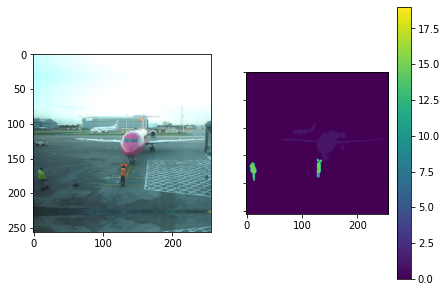

In [ ]:
img,lbl = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

In [ ]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr = 3e-5, weight_decay = 1e-5)
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [ ]:
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [ ]:
def IoU(predict, mask):
    predict = predict.softmax(1)
    with torch.no_grad():
        intersection = (predict * mask).sum([2, 3])
        union = (predict + mask).sum([2, 3])
    return intersection / union

def MIoU(predict, mask):
    iou = IoU(predict, mask)
    return iou.sum(1) / iou.count_nonzero(1)

In [ ]:
next_desc = "first epoch"
val_miou_mean = []
val_r_losses = []

for epoch in range(5):
  
    val_iou = []
    val_miou = []

    for img, lbl in tqdm(dataloader, desc = next_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()
    
    #Считаем на валидационной выборке
    rloss = 0
    model.eval()
    for img2, lbl2 in val_loader:
        with torch.no_grad():
            img2 = img2.cuda()
            lbl2 = lbl2.cuda()
            predict = model(img2)['out']
            loss = crit(predict, lbl2)
            rloss += loss.detach().cpu().item() / len(val_loader)

            val_miou.extend(MIoU(predict, lbl2).cpu().tolist())
            val_iou.extend(IoU(predict, lbl2).cpu().tolist())

    val_miou = np.array(val_miou)
    val_iou = np.array(val_iou)

    val_miou_mean.append(val_miou.mean())
    val_r_losses.append(rloss)

    next_desc = f"Epoch: [{epoch + 1}], previous rloss: [{rloss:.3f}], val_miou_mean[{val_miou_mean[-1]:.3f}]"
    rloss = 0

first epoch: 100%|██████████| 183/183 [03:38<00:00,  1.20s/it]
Epoch: [1], previous rloss: [0.211], val_miou_mean[0.380]: 100%|██████████| 183/183 [03:37<00:00,  1.19s/it]
Epoch: [2], previous rloss: [0.225], val_miou_mean[0.377]: 100%|██████████| 183/183 [03:37<00:00,  1.19s/it]
Epoch: [3], previous rloss: [0.222], val_miou_mean[0.380]: 100%|██████████| 183/183 [03:36<00:00,  1.18s/it]
Epoch: [4], previous rloss: [0.218], val_miou_mean[0.382]: 100%|██████████| 183/183 [03:31<00:00,  1.16s/it]


[]

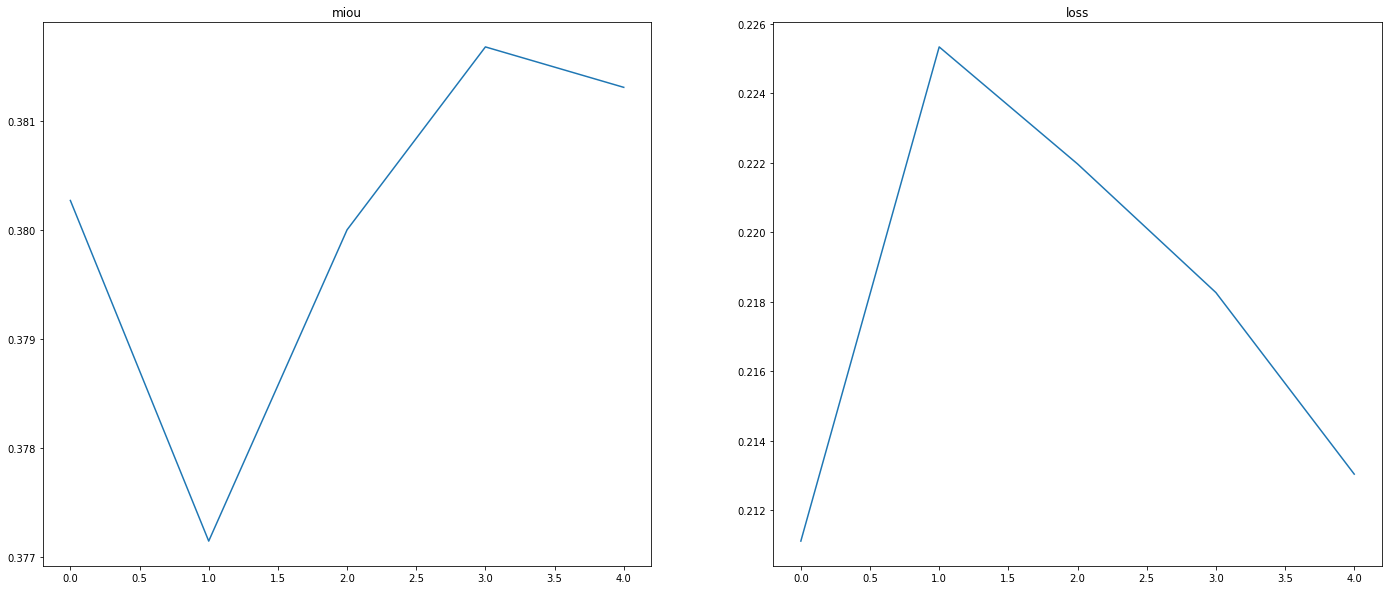

In [ ]:
figure = plt.figure(figsize = (24, 10))
t = np.arange(0, 5)

ax1 = figure.add_subplot(1, 2, 1)
ax2 = figure.add_subplot(1, 2, 2)

ax1.set_title("miou")
ax1.plot(t, val_miou_mean)

ax2.set_title("loss")
ax2.plot(t, val_r_losses)

plt.plot()

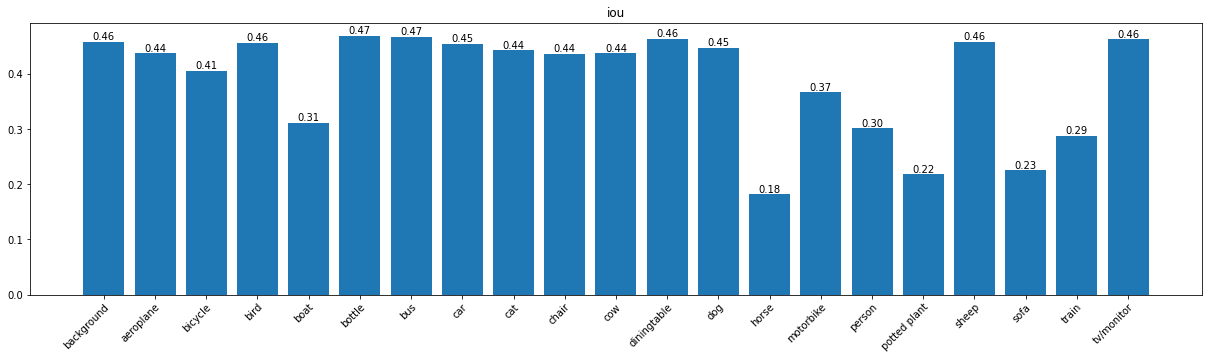

In [ ]:
res = np.zeros((val_iou.shape[1],))
for i in range(val_iou.shape[1]):
    res[i] = val_iou[i, val_iou[i, :] > 0].mean()
_, ax = plt.subplots(figsize=(21, 5))
ax.set_xticks(range(len(VOC_CLASSES)), labels = VOC_CLASSES)
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.title('iou')
bars = plt.bar(range(len(VOC_CLASSES)), res)
plt.bar_label(bars, labels=['%.2f' % i for i in res])
plt.show()

In [ ]:
def top_percent_images(model, val, miou, low, high, k=2):

    title = f'From {low}% to {high}%'
    low = 1 - high / 100
    high = 1 - low / 100
    
    mask1 = miou > np.quantile(miou, low)
    mask2 = miou < np.quantile(miou, high)
    mask = mask1 & mask2
    idx = choices(np.arange(len(miou))[mask], k = k)
    

    fig, axes = plt.subplots(1, 3, figsize = (12, 4))
    axes[0].imshow(val[idx[0]][0].permute(1, 2, 0))
    axes[1].imshow(model(val[idx[0]][0].expand(1, -1, -1, -1).cuda())['out'].cpu()[0].softmax(0).argmax(0), vmin = 0, vmax = len(VOC_CLASSES), cmap = VOC_COLORS, interpolation = 'nearest')
    axes[2].imshow(val[idx[0]][1].argmax(0), vmin = 0, vmax = len(VOC_CLASSES), cmap = VOC_COLORS, interpolation = 'nearest')

    fig.suptitle(title, size=16)
    plt.show()

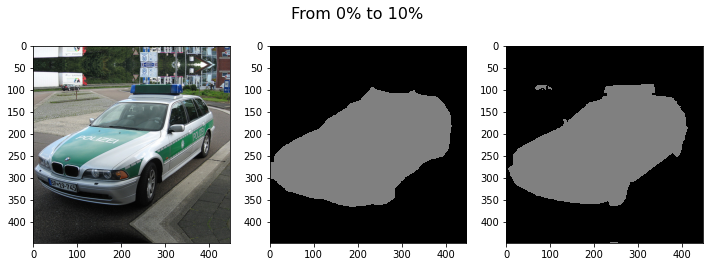

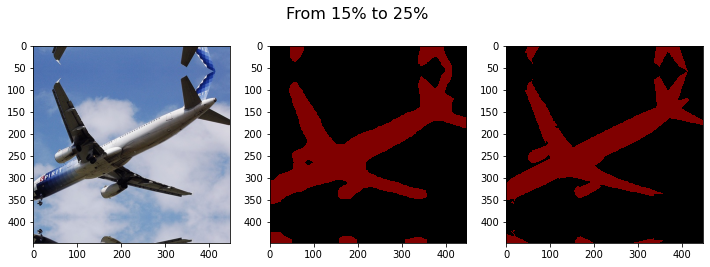

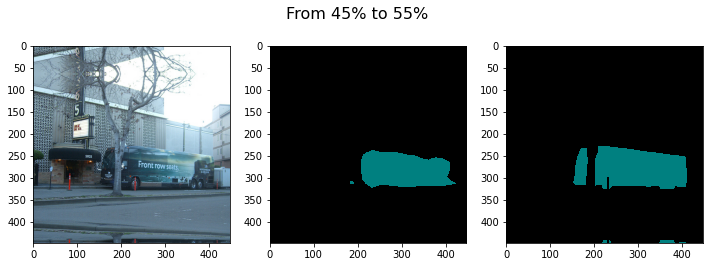

In [ ]:
top_percent_images(model, val_dataset, val_miou, 0, 10)
print()
top_percent_images(model, val_dataset, val_miou, 15, 25)
print()
top_percent_images(model, val_dataset, val_miou, 45, 55)

In [ ]:
def top_class_image(model, val, iou, n_class):
    idx = iou[:, n_class].argmax()

    fig, axes = plt.subplots(1, 3, figsize = (12, 4))
    axes[0].imshow(val[idx][0].permute(1, 2, 0))
    axes[1].imshow(model(val[idx][0].expand(1, -1, -1, -1).cuda())['out'].cpu()[0].softmax(0).argmax(0), vmin = 0, vmax = len(VOC_CLASSES), cmap = VOC_COLORS, interpolation = 'nearest')
    axes[2].imshow(val[idx][1].argmax(0), vmin = 0, vmax = len(VOC_CLASSES), cmap = VOC_COLORS, interpolation = 'nearest')

    fig.suptitle(f'Class: {VOC_CLASSES[n_class]}, IoU: {iou[idx][n_class]:.4f}', size=16)
    plt.show()

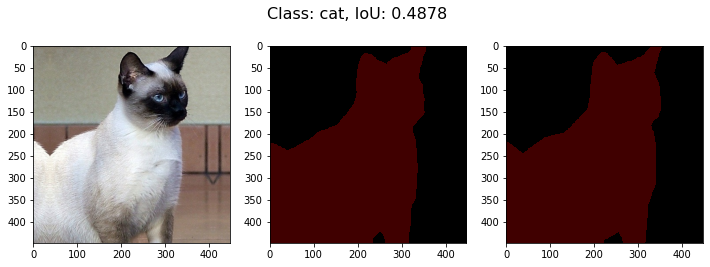

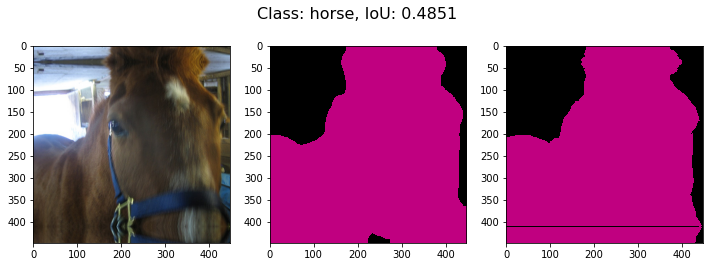

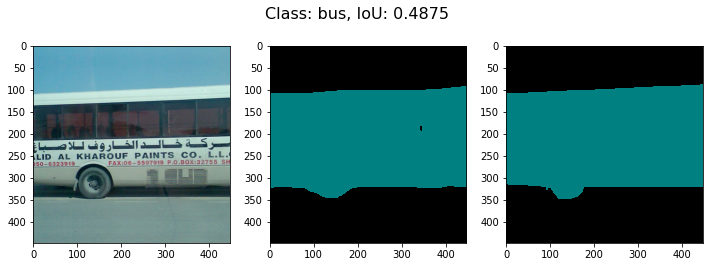

In [ ]:
idx = choices(np.arange(1, len(VOC_CLASSES)), k = 3)
for i in idx:
    top_class_image(model, val_dataset, val_iou, i)

#### Задание 
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам.
(пользоваться уже написанным IoU)
5. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в csv табличку: номер пуска: MIoU в среднем по классам)
4. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
5. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
6. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.
* Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив).
** При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять. 



